In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.iolib.table import SimpleTable
warnings.filterwarnings("ignore")

Загружаем временной ряд

In [2]:
data = pd.read_excel('ts.xlsx', index_col=0, parse_dates=['Дата'], dayfirst=True)
data.head()

,Значение
Дата,
2014-05-01,0
2014-05-02,10
2014-05-03,0
2014-05-04,0
2014-05-05,0


Строим график временного ряда

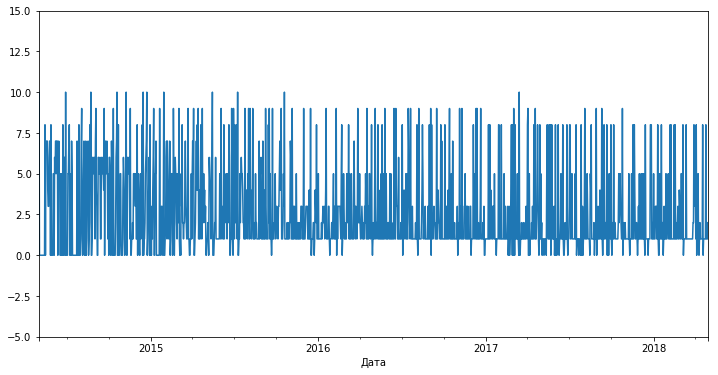

In [3]:
values = data['Значение']
values.plot(figsize=(12,6), ylim=(-5, 15));

На графике временного ряда зметно отсутвие трендов или каки-либо сезонных

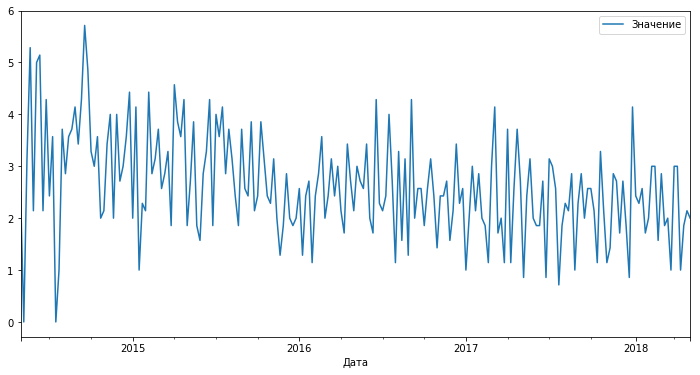

In [4]:
week_data = data.resample('W').mean()
week_data.plot(figsize=(12,6));

По прежнему временной ряд не дает очевидной характеристики. Наблюдаются случайные выбросы. Построим новый ряд на основании исходного со смещением периода, что опеределить, если ли тренд.

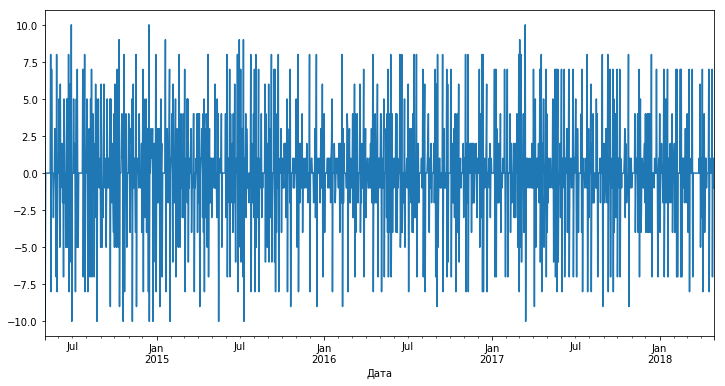

In [5]:
vdiff = values.diff(periods=1).dropna()
vdiff.plot(figsize=(12, 6));

Какой-либо тренд явно отсутствует, что вызывает предположение о стационарности временного ряда. Ряд можно считать стационарным, если соблюдается условие о равенстве статистик (матюожидание, дисперсия и т.д). Разобьем временной ряд на разные интервальные промежутки и найдем вероятность того, что мат.ожидание на каждом интервале одинаково, а следовательно и другие стаитстики

In [6]:
m = vdiff.index[int(len(vdiff) / 2 + 1)]
r1 = sm.stats.DescrStatsW(vdiff[m:])
r2 = sm.stats.DescrStatsW(vdiff[:m])
print('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.9999769441138951


Почти с вероятностью в 100%  мат ожидание на всех интревалах временного ряда одинаково, что говорит о стационарности временного ряда

Дополнительно используем тест Дикки-Фуллера для проверки стационарности ряда

In [7]:
test = sm.tsa.adfuller(data['Значение'])
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -38.31485742676612
p-value:  0.0
Critical values:  {'1%': -3.434836872962171, '5%': -2.863521656701378, '10%': -2.567825016419591}
единичных корней нет, ряд стационарен


Проверим временной ряд на нормальное распределение с помощью теста Харки-Бера

In [8]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data['Значение'])
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB                p-value                skew             kurtosis    
------------------------------------------------------------------------------
349.77651484518356 1.1142813243601544e-76 1.1910610693009291 3.267038491079774
------------------------------------------------------------------------------


Значение p-value очень близко к 0, что меньше уровня значимости 0.05. Соответственно временной ряд не имеет нормального распределения. Убедимся в этом на гистограмме

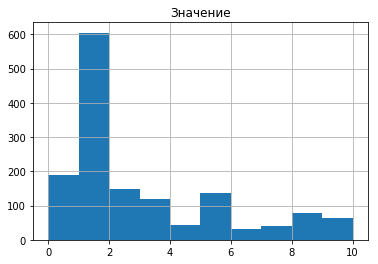

In [9]:
data.hist();

Гистограмма не содержит даже намека на нормальное распределение. Большинство наблюдений сконцентрированны сконцентрированы вокруг значения равному 1. Итого: временной ряд не содержит тренда и сезонности, не имеет нормального распределения, а так же является стационарным. Соответсвенно данный временной ряд можно описать простой скользящей средней и использовать её для прогноза

In [10]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

Средняя квадратическая ошибка - 5.722474833333935, Средняя абсолютная ошибка - 1.9173313840916415 


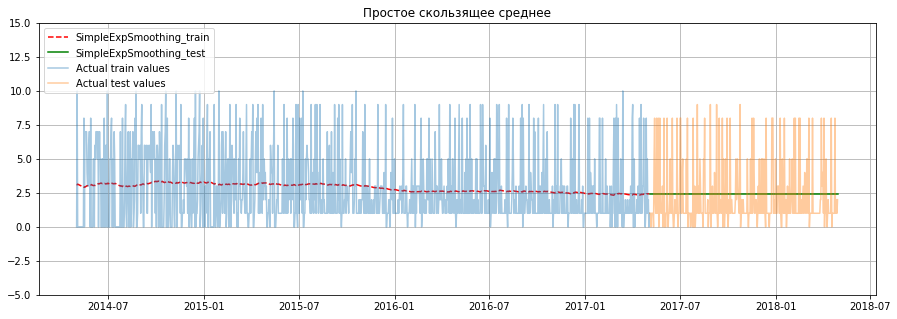

In [11]:
train, test = data[:1100], data[1100:]

model = SimpleExpSmoothing(train).fit()
pred_train = model.predict(start=train.index[0], end=train.index[-1])
pred_test = model.predict(start=test.index[0], end=test.index[-1])
MSE = mean_squared_error(pred_test, test)
MAE = mean_absolute_error(pred_test, test)
print(f'Средняя квадратическая ошибка - {MSE}, Средняя абсолютная ошибка - {MAE} ')

plt.figure(figsize=(15,5))
plt.title("Простое скользящее среднее")
plt.plot(pred_train, "r--", label="SimpleExpSmoothing_train")
plt.plot(pred_test, "g", label="SimpleExpSmoothing_test")


plt.plot(train, label="Actual train values", alpha=0.4)
plt.plot(test, label="Actual test values", alpha=0.4)
plt.legend(loc="upper left")
plt.ylim((-5, 15))
plt.grid(True)

In [12]:
model.forecast(1)

2017-05-05    2.40418
Freq: D, dtype: float64